In [177]:
# Imports
import ezbci_lite as ez
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame with appropriate column names
csv_file_path = 'EMG_data_compiled.csv'  # Change this to your local file path
column_names = ['time', 'channel1', 'channel2', 'channel3', 'channel4',
                'channel5', 'channel6', 'channel7', 'channel8', 'class', 'UserID', 'Trial', 'Date']

df = pd.read_csv(csv_file_path, header=0, names=column_names)
df.dropna(axis=0, how='any', inplace=True)

In [178]:
# Define the mapping from numerical classes to letter codes
class_mapping = {
    0: 'U',  # unmarked data
    1: 'A',  # hand at rest
    2: 'C',  # hand clenched in a fist
    3: 'F',  # wrist flexion
    4: 'D',  # wrist extension
    5: 'R',  # radial deviations
    6: 'L',  # ulnar deviations
    7: 'E'   # extended palm
}

# Replace the numerical classes with letter codes in the original DataFrame
df['class'] = df['class'].replace(class_mapping)

In [179]:
# Show the first few rows of the dataframe
df.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,UserID,Trial,Date
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,U,1,1,22
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,U,1,1,22
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,U,1,1,22
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,U,1,1,22
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,U,1,1,22


In [180]:
# Show the last few rows of the dataframe
df.tail()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,UserID,Trial,Date
4237903,54832,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,U,36,1,15
4237904,54833,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,U,36,1,15
4237905,54834,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,U,36,1,15
4237906,54835,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,U,36,1,15
4237907,54836,-0.00004,-0.00005,-0.00008,-0.00006,-0.00003,-0.00001,-0.00001,-0.00001,U,36,1,15


In [181]:
def plot_raw_emg_data(user_id, class_label, df):
    # Define the mapping from class labels to the letter codes used in df['class']
    label_mapping = {
        'unmarked': 'U',
        'rest': 'A',
        'clenched': 'C',
        'flexUp': 'F',
        'flexDown': 'D',
        'flexRight': 'R',
        'flexLeft': 'L',
        'extendPalm': 'E'
    }
    
    # Get the letter code for the provided class label
    class_code = label_mapping[class_label]

    # Filter the data for the specified class code and user ID
    user_data = df[(df['class'] == class_code) & (df['UserID'] == user_id)]

    # Calculate the RMS for each row across the 8 EMG channels and convert to millivolts
    user_data['rms_voltage_mV'] = np.sqrt((user_data.iloc[:, 1:9] ** 2).mean(axis=1)) * 1000

    # Now plot the RMS voltage vs time in millivolts
    plt.figure(figsize=(12, 6))  # Adjust the figure size as desired
    plt.plot(user_data['time'], user_data['rms_voltage_mV'], label='RMS Voltage', color='blue')

    plt.title(f'RMS Voltage {class_label.capitalize()} vs Time for User={user_id}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of how to use the function:
# plot_raw_emg_data(user_id=1, class_label='clenched', df=df)

In [196]:
from scipy.signal import firwin, lfilter

# Assume 'df' is your original DataFrame containing the EMG data

# Define your sampling rate
sampling_rate = 200  # for MYO Thalmic bracelet 

# Filter parameters
nyquist = sampling_rate / 2
low_cut = 0.1 / nyquist
high_cut = 125 / nyquist
num_taps = 101  # Number of filter taps (coefficients)

# Use firwin to create a bandpass FIR filter
coeffs = firwin(num_taps, [low_cut, high_cut], pass_zero=False, fs=sampling_rate)

# Initialize an empty DataFrame to store the filtered data
filtered_EMG = pd.DataFrame(index=df.index)

# Apply the filter to each channel for each user
for channel in ['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8']:
    filtered_EMG[channel] = lfilter(coeffs, 1.0, df[channel])

# Now, filtered_EMG contains the filtered data for each channel

# Proceed with creating features and targets for machine learning as shown before


In [206]:
from scipy.signal import firwin, lfilter
import matplotlib.pyplot as plt
import numpy as np

def plot_filtered_emg_data(user_id, class_label, df, sampling_rate):
    # Define the mapping from class labels to the letter codes used in df['class']
    label_mapping = {
        'unmarked': 'U',
        'rest': 'A',
        'clenched': 'C',
        'flexUp': 'F',
        'flexDown': 'D',
        'flexRight': 'R',
        'flexLeft': 'L',
        'extendPalm': 'E'
    }
    
    # Get the letter code for the provided class label
    class_code = label_mapping[class_label]

    # Filter parameters
    nyquist = sampling_rate / 2
    low_cut = 0.1 / nyquist
    high_cut = 125 / nyquist
    num_taps = 101  # Number of filter taps (coefficients)

    # Use firwin to create a bandpass FIR filter
    coeffs = firwin(num_taps, [low_cut, high_cut], pass_zero=False, fs=sampling_rate)

    # Filter the data for the specified class code and user ID
    user_data = df[(df['class'] == class_code) & (df['UserID'] == user_id)].copy()

    # Apply the filter to each channel and calculate RMS in millivolts
    user_data_filtered = pd.DataFrame()
    for i in range(1, 9):  # Assuming there are 8 channels
        channel = f'channel{i}'
        filtered_channel = lfilter(coeffs, 1.0, user_data[channel])
        user_data_filtered[channel] = filtered_channel

    # Calculate the RMS for each row across the 8 EMG channels and convert to millivolts
    rms_voltage_mV = np.sqrt((user_data_filtered ** 2).mean(axis=1)) * 1000

    # Now plot the RMS voltage vs time in millivolts
    plt.figure(figsize=(12, 6))  # Adjust the figure size as desired
    plt.plot(user_data['time'], rms_voltage_mV, label='RMS Voltage', color='blue')

    plt.title(f'Filtered RMS Voltage {class_label.capitalize()} vs Time for User={user_id}')
    plt.xlabel('Time (ms)')
    plt.ylabel('RMS Voltage (mV)')  # Updated to millivolts
    plt.legend()
    plt.grid(True)  # Optional: Adds a grid to the plot for better readability
    plt.show()

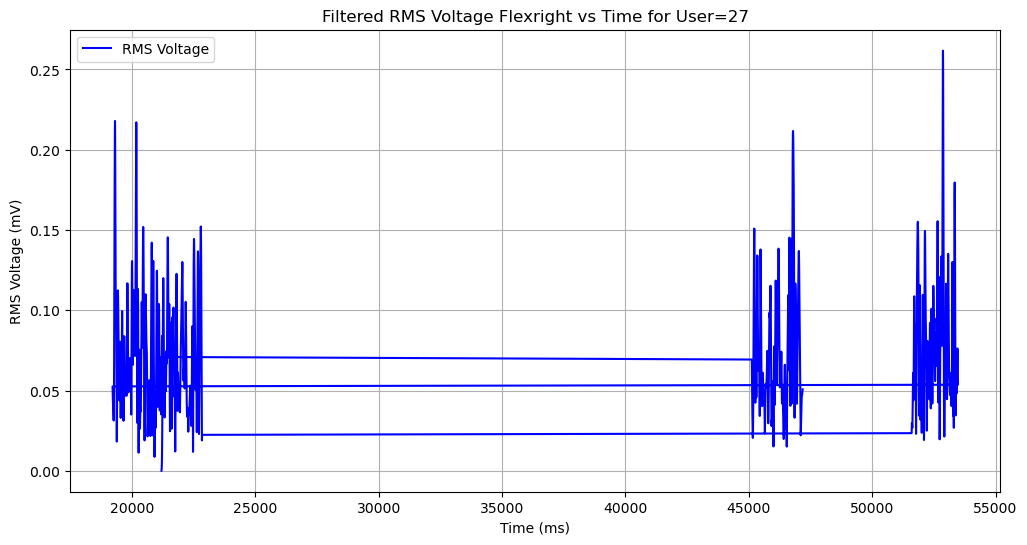

In [207]:
plot_filtered_emg_data(user_id=27, class_label='flexRight', df=df, sampling_rate=200)

In [211]:
# Assuming the 'mean_rms_voltage' column is in 'df' and corresponds to filtered EMG data
df['mean_rms_voltage'] = filtered_EMG['rms_voltage']

# Prepare the feature matrix X and the target vector y
X = df[['mean_rms_voltage']]  # Add more features as needed
y = df['class']  # This should align with X

# Define boolean masks for training and testing based on user ID
train_index = df['UserID'] <= 30
test_index = df['UserID'] > 30

# Use boolean masks to split the data, ensuring index alignment
X_train = X.loc[train_index]
y_train = y.loc[train_index]
X_test = X.loc[test_index]
y_test = y.loc[test_index]

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by RandomForestClassifier.